In [1]:
import ee

import pandas as pd 
import matplotlib.pyplot as plt
import sys 

import numpy as np 
sys.path.append('../geoindexity')

In [2]:
# In order to use GEE (its EO data collections AND computing resources) we have to authentificate
# and to initialize the project we want to work in. 
ee.Authenticate()
ee.Initialize()

In [3]:
class time_series:
    """
    The core geoindexity time series object. 
    ...

    Attributes
    ----------
    aoi : list
        [xmin, ymin, xmax, ymax]
    startdate : str
        'yyyy-mm-dd'
    enddate : str
        'yyyy-mm-dd'
    product: str 
        GEE data set: 'S1', 'S2_TOA', 'S2_SR' 
    cloudcover: int 
        percentage cloudcover threshold for series
    collection: ee.imagecollection.ImageCollection 
        the actual image collection as input for index 
        time-series

    Methods
    -------
    fetch_data(self):
        Fetches GEE Image collection based on the following time_series attributes:
        product, aoi, startdate, enddate, cloudcover

    """
    def __init__(self, aoi, startdate, enddate, product, cloudcover):
        data_dict = {'S1': 'COPERNICUS/S1_GRD', 
             'S2_TOA': 'COPERNICUS/S2_HARMONIZED',
             'S2_SR': 'COPERNICUS/S2_SR_HARMONIZED'}
        
        self.aoi = ee.Geometry.Rectangle(aoi)
        self.startdate = startdate
        self.enddate = enddate
        self.product = data_dict[product] 
        self.cloudcover = cloudcover
        self.collection = None

    def __len__(self): 
        if self.collection != None:
            return self.collection.size().getInfo()
        else: 
            return 0

    def fetch_data(self): 
        """
        Fetches GEE Image collection based on the following time_series attributes:
        product, aoi, startdate, enddate, cloudcover
        ...
        Images with cloud percentage <= cloudcover are used for the collection
        """
        ee_collection = ee.ImageCollection(self.product)
        self.collection = ee_collection.filterBounds(self.aoi).filterDate(self.startdate, self.enddate).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', self.cloudcover))    

In [4]:
aoi = [-2.9,
       47.48,
       -2.6,
       47.63
      ]

ts = time_series(aoi,
            startdate='2023-06-01',
            enddate='2023-08-30', 
            product= 'S2_SR', 
            cloudcover=10)

In [5]:
len(ts) 

0

In [6]:
ts.fetch_data()

In [7]:
len(ts)

7

In [8]:
type(ts.collection)

ee.imagecollection.ImageCollection

## Testing 26/06

In [8]:
from config import *

In [9]:
class Sentinel:
    """
    A class that represents the user speci
    """
    def __init__(self, roi, start_date, end_date, properties=None):
        self.roi = roi
        self.start_date = start_date
        self.end_date = end_date
        self.collection_id= 'COPERNICUS/S2_SR_HARMONIZED'
        self.properties = properties or {}

    def bound(self):
        return ee.Geometry.Rectangle(self.roi)

    def select_product(self):
        image_collection = ee.ImageCollection(self.collection_id)
        image_collection = image_collection.filterDate(self.start_date, self.end_date)
        image_collection = image_collection.filterBounds(self.bound())
        if self.properties:
            valid_properties = {"CLOUDY_PIXEL_PERCENTAGE": int, "CLOUDY_SHADOW_PERCENTAGE": int, "DARK_FEATURES_PERCENTAGE": int}
            for property_name, value in self.properties.items():
                if property_name not in valid_properties:
                    raise KeyError(f"Invalid property name: {property_name}. Supported properties: {', '.join(valid_properties.keys())}.")
                image_collection=image_collection.filter(ee.Filter.lte(property_name, value))
        return image_collection

    def number_of_images(self):
        print(f'Total Sentinel images collected: {self.select_product().size().getInfo()}')

In [10]:
class Landsat8:
    """
    A class that represents the user speci
    """
    def __init__(self, roi, start_date, end_date, properties=None):
        self.roi = roi
        self.start_date = start_date
        self.end_date = end_date
        self.collection_id= 'LANDSAT/LC08/C02/T1_L2'
        self.properties = properties or {}

    def bound(self):
        return ee.Geometry.Rectangle(self.roi)

    def select_product(self):
        image_collection = ee.ImageCollection(self.collection_id)
        image_collection = image_collection.filterDate(self.start_date, self.end_date)
        image_collection = image_collection.filterBounds(self.bound())
        if self.properties:
            valid_properties = {"CLOUDY_PIXEL_PERCENTAGE": int, "CLOUDY_SHADOW_PERCENTAGE": int, "DARK_FEATURES_PERCENTAGE": int}
            for property_name, value in self.properties.items():
                if property_name not in valid_properties:
                    raise KeyError(f"Invalid property name: {property_name}. Supported properties: {', '.join(valid_properties.keys())}.")
                image_collection=image_collection.filter(ee.Filter.lte(property_name, value))
        return image_collection

In [93]:
class Geoindexity:
    """
    The core geoindexity time series object. 
    ...

    Attributes
    ----------
    aoi : list
        [xmin, ymin, xmax, ymax]
    startdate : str
        'yyyy-mm-dd''
    enddate : str
        'yyyy-mm-dd'
    collection: str 
        default: 'Sentinel', 'Landsat' 
    properties: dict 
        percentage cloudcover threshold for series

    Methods
    -------
    fetch_data(self):
        Fetches GEE Image collection based on the following time_series attributes:
        product, aoi, startdate, enddate, cloudcover

    """
    # Will be changed accordingly to the config file parameters

    def __init__(self, roi, start_date, end_date, collection_id='Sentinel', properties=None): # collection argument as identifier between Sentinel and Landsat? 
        self.roi = roi
        self.start_date = start_date
        self.end_date = end_date
        self.collection_id = collection_id
        self.properties = properties
        self.reducer = None 
        self.df = None 

        if self.collection_id == 'Sentinel':
            self.collection = Sentinel(roi=self.roi,
                                       start_date=self.start_date,
                                       end_date=self.end_date,
                                       properties=self.properties
                                       ).select_product()

        if self.collection_id == 'Landsat8':
            self.collection = Landsat8(roi=self.roi,
                                       start_date=self.start_date,
                                       end_date=self.end_date,
                                       properties=self.properties
                                       ).select_product()

    def __len__(self):
        return self.collection.size().getInfo()

    def bound(self):
        return ee.Geometry.Rectangle(self.roi)

    def add_ndvi(self, image):
        if self.collection_id == 'Sentinel':
            ndvi = image.expression(
                '((nir-red)/(nir+red))',
                {'nir': image.select('B4'),
                 'red': image.select('B8')}
            ).rename('NDVI')
        elif self.collection == 'Landsat8':
            ndvi = image.expression(
                '((nir - red)/(nir + red))',
                {'nir': image.select('SR_B5'),
                 'red': image.select('SR_B4')}
            ).rename('NDVI')

        return image.addBands(ndvi)


    def add_evi(self, image):
        if self.collection == 'Sentinel':
            evi = image.expression(
                '2.4*((nir-red)/(nir+ 6*red - 7.5* blue +1))',
                {'nir': image.select('SR_B8'),
                 'red': image.select('SR_B4'),
                 'blue': image.select('SR_B2')}
            ).rename('EVI')


        elif self.collection == 'Landsat8':
            evi = image.expression(
                '(2.5 * (nir–red) / (nir + 6 * red – 7.5 * blue + 1)', # Change to Landsat8 here!
                {'nir': image.select('SR_B5'),
                 'red': image.select('SR_B4'),
                 'blue': image.select('SR_B2')}
            ).rename('EVI')

        return image.addBands(evi)

    def ndvi_collection(self):
        self.collection = self.collection.map(self.add_ndvi)

    def evi_collection(self):
        self.collection = self.collection.map(self.add_evi)

    def reduce_ndvi_mean(self):

        # Check if NDVI in collection 
        if not 'NDVI' in x.collection.first().bandNames().getInfo():
            raise ValueError(f"No NDVI band found. Use ndvi_collection method first to calculate NDVI")

        # If NDVI in collection do:
        else:
            aoi = self.bound()
    
            def aoi_ndvi_mean(image, aoi=aoi):
                # Extract the date from the image metadata
                date = ee.Date(image.get('system:time_start')).format("YYYY-MM-dd", 'UTC')
            
                # Calculate the mean NDVI value within the AOI
                mean = image.select('NDVI').reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=aoi
                ).get('NDVI')
            
                # Return the date and mean NDVI as a feature
                return ee.Feature(None, {
                    'date': date,
                    'mean_ndvi': mean
                })
    
            features= self.collection.map(aoi_ndvi_mean).getInfo()
        
            # Extract dates and mean NDVI values from the feature collection
            dates = [feature['properties']['date'] for feature in features['features']]
            mean_ndvi = [features['properties']['mean_ndvi'] for features in features['features']]
        
            # Create a DataFrame from the extracted data
            df = pd.DataFrame({
                'Date': dates,
                'Mean_NDVI': mean_ndvi
            })
        
            # Sort the DataFrame by date
            df_sorted = df.sort_values(by='Date')
        
            self.df = df_sorted
            self.reducer = 'NDVI_MEAN'


    def plot(self):
        if not self.reducer:
            raise ValueError(f"Time-series not reduced yet. Use reducer function based on your selected Index")

        if self.reducer == 'NDVI_MEAN':            
            plt.figure(figsize=(10, 5))
            plt.plot(self.df['Date'], self.df['Mean_NDVI'], marker='o', linestyle='--')
            plt.title('Mean NDVI Time Series')
            plt.xlabel('Date')
            plt.xticks(rotation=45)
            plt.ylabel('Mean NDVI')
            plt.yticks(np.arange(-1, 1, 0.5))
            plt.grid(True)
            plt.show()
            
        

In [94]:
x = Geoindexity(roi, start_date, end_date, collection_id='Sentinel')

In [95]:
x.reduce_ndvi_mean()

ValueError: No NDVI band found. Use ndvi_collection method first to calculate NDVI

In [96]:
x.ndvi_collection()

In [97]:
x.reducer

In [98]:
x.reducer == None

True

In [99]:
x.plot()

ValueError: Time-series not reduced yet. Use reducer function based on your selected Index

In [100]:
x.reduce_ndvi_mean()

In [101]:
print(x.reducer) 
x.df

NDVI_MEAN


,Date,Mean_NDVI
0,2020-01-01,-0.566154
1,2020-01-01,-0.517421
2,2020-01-01,-0.493941
3,2020-01-04,-0.017627
4,2020-01-04,-0.020999
...,...,...
107,2020-03-16,-0.613510
110,2020-03-19,-0.564921
108,2020-03-19,-0.607619
109,2020-03-19,-0.563522


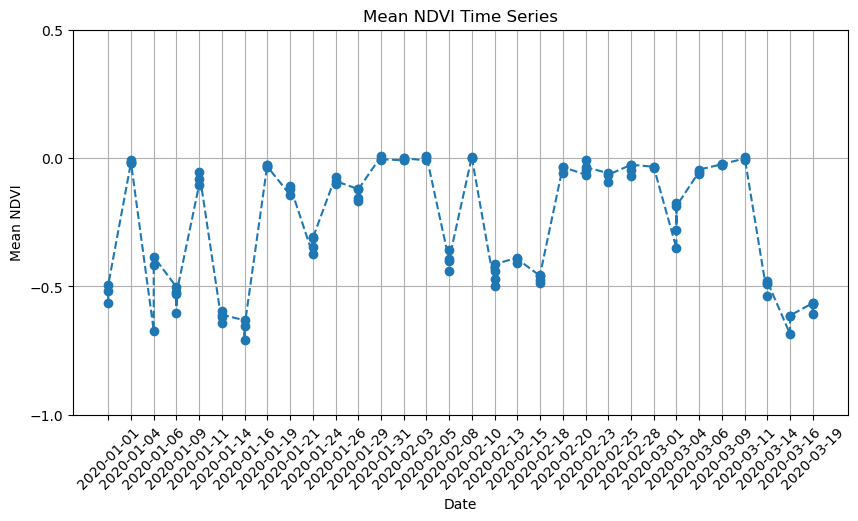

In [102]:
x.plot() 

In [88]:
'NDVI' in x.collection.first().bandNames().getInfo()

True

# Testing 16/97/2024

In [3]:
import geoindexity 

In [5]:
from geoindexity import Geoindexity 

ImportError: cannot import name 'Geoindexity' from 'geoindexity' (C:\Users\davha\anaconda3\envs\test_geoindexity\Lib\site-packages\geoindexity\__init__.py)

Tutorial workthrough

In [4]:
from example_package_hansendav import example  

In [6]:
example.add_one(1)

2

In [10]:
import geoindexity.geoindexity as gx 

In [11]:
gx.Geoindexity

geoindexity.geoindexity.Geoindexity

In [12]:
import geoindexity 

In [13]:
geoindexity.geoindexity.Geoindexity

geoindexity.geoindexity.Geoindexity

Just made a simple import mistake at the beginning **...**

In [1]:
import ee 
ee.Initialize() 
ee.Authenticate()

True

In [2]:
from geoindexity import geoindexity as gx 

In [3]:
from geoindexity.examples import * 

In [5]:
print(properties) 

{'CLOUDY_PIXEL_PERCENTAGE': 10}


In [14]:
x = gx.Geoindexity(roi, start_date, end_date, properties=properties, collection_id = 'Sentinel')

In [7]:
x.collection_id

'Sentinel'

In [8]:
x.ndvi_collection() 

In [9]:
x.reduce_ndvi_mean()

In [10]:
len(x)

20

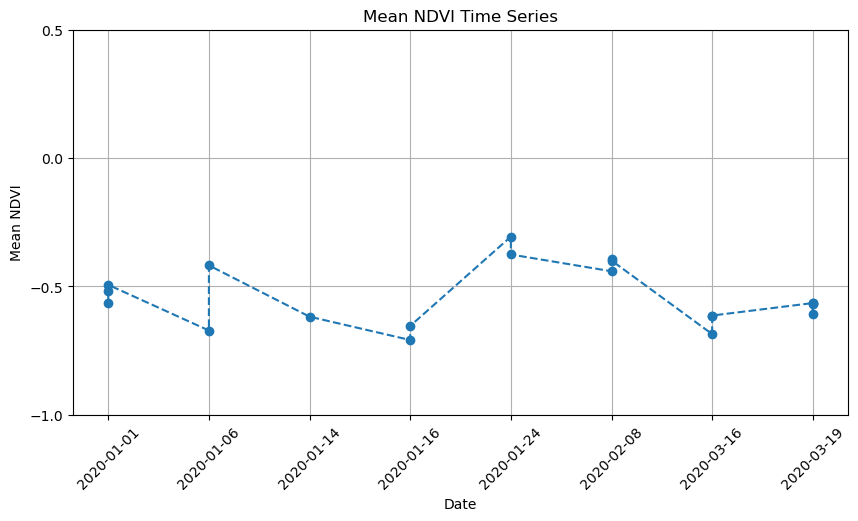

In [11]:
x.plot()

In [12]:
x.df

,Date,Mean_NDVI
0,2020-01-01,-0.566154
1,2020-01-01,-0.517421
2,2020-01-01,-0.493941
3,2020-01-06,-0.671886
4,2020-01-06,-0.418100
5,2020-01-14,-0.617990
6,2020-01-16,-0.708925
7,2020-01-16,-0.653999
9,2020-01-24,-0.306296
8,2020-01-24,-0.375750


# Environment and example test 
Test done with freshly installed conda environment. 

In [1]:
import ee 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
ee.Initialize() 
ee.Authenticate() 

True

In [3]:
import geoindexity.geoindexity as gx

In [4]:
roi = [
    12.90,
    47.75,
    13.20,
    47.85,
]
start_date = '2020-01-01'
end_date  = '2020-03-20'
properties = {
    'CLOUDY_PIXEL_PERCENTAGE':10
}

ts = gx.Geoindexity(roi, start_date, end_date, properties=properties, collection_id='Sentinel')

gx.ndvi_collection() 
gx.reduce_ndvi_mean()
gx.plot() 

AttributeError: module 'geoindexity.geoindexity' has no attribute 'ndvi_collection'

In [5]:
help(gx)

Help on module geoindexity.geoindexity in geoindexity:

NAME
    geoindexity.geoindexity - This script includes the core GeoIndexity classes and functions.

DESCRIPTION
    GeoIndexity classes and functions are based on the Earth Engine API
    for Google Earth Engine (GEE). A valid GEE account is therefore
    necessary to use GeoIndexity. For more information on setting up your
    GEE account and using GeoIndexity, please see https://github.com/ro-hit81/GeoIndexity/blob/main/README.md

CLASSES
    builtins.object
        Geoindexity
        Landsat
        Sentinel

    class Geoindexity(builtins.object)
     |  Geoindexity(roi, start_date, end_date, collection_id='Sentinel', properties=None)
     |
     |  The core Geoindexity time-series object.
     |  After initializaton funcionality can be used to calculate indices, plot time-series export
     |  time-series data.
     |  ...
     |
     |  Attributes
     |  ----------
     |  roi : list
     |      The region of interest def